# Introduction

A couple of papers, arXiv:1510.01691, arXiv:1812.07591, have used deep learning to determine the polarization fraction, $W_L W_L / \sum_{i,j} W_i W_j$, in same-sign $WW$ scattering. 

In this reaction two protons ($p$) collide (at the Large Hadron Collider) and produce two jets ($j$), collimated sprays of hadronic particles, and two $W$ bosons with the same electric charge. The process is written as  $p p \to j j W^{\pm} W^{\pm}$. This process is interesting as a probe of the unitarization (probability conservation) mechanism in the Standard Model (SM) of particle physics.

The polarization fraction is predicted to be small in the SM, ~5%. Thus there is (predicted to be) an imbalance of events where both $W$s are longitudinally polarized vs. when one or none is longitudinally polarized. This motivates trying to treat this as a class imbalance problem, something which neither of the above papers do.

# Process Data

load 160k MadGraph events for $p p \to j j W^{\pm} W^{\pm}$

In [2]:
import numpy as np
import pandas as pd
import sys

In [3]:
sys.path.append('../')

In [4]:
from src.processing import processData

In [5]:
process_data = processData()

In [7]:
dfww = (process_data.get_pT_sorted_events('../data/jjWpmWpm_undecayed_01.csv')
        .append(process_data.get_pT_sorted_events('../data/jjWpmWpm_undecayed_02.csv'), ignore_index=True)
        .append(process_data.get_pT_sorted_events('../data/jjWpmWpm_undecayed_03.csv'), ignore_index=True))

Preview the data. Note that $j_1$ or $j_2$ ($W_1$ or $W_2$) refers to the jet ($W$) with the larger or smaller $p_T$. This is an important feature engineering step that improves the performance of the classifiers. MadGraph does not do this.

In [8]:
dfww.head()

,delta_eta.jj,delta_phi.jj,e.W1,e.W2,e.WW,e.j1,e.j2,eta.W1,eta.W2,eta.WW,...,pT.W1,pT.W2,pT.WW,pT.j1,pT.j2,phi.W1,phi.W2,phi.WW,phi.j1,phi.j2
0,0.937818,2.526961,260.022369,86.647179,346.669556,334.820129,108.411491,1.655412,-0.002248,0.860839,...,52.132881,32.256462,53.513283,92.130432,68.857269,2.156915,0.316870,1.536887,-0.768650,2.987575
1,4.616750,2.832147,808.807922,849.306519,1658.114380,541.339111,204.516388,-2.355237,2.518277,0.026521,...,129.096603,109.702820,28.469536,76.190239,56.073837,-1.289668,2.027286,-2.026936,1.757915,-1.074232
2,1.427670,2.811202,248.391281,115.091896,363.483185,405.223480,352.797760,-0.818359,-0.227817,-0.592401,...,164.888992,78.195580,184.492783,378.077942,219.811966,0.447415,-1.094888,0.009923,-2.734816,0.737167
3,1.445657,2.697355,499.050507,144.236588,643.287109,111.540321,58.250736,2.136573,-0.713417,0.720226,...,83.896637,80.772057,61.255695,95.844513,41.203468,0.964510,-2.938495,2.107226,-0.741097,2.844733
4,1.696952,2.378781,101.424492,318.868713,420.293213,89.005386,204.175339,0.207836,-2.049945,-0.837528,...,58.205227,7.466976,63.719795,88.129692,82.474373,-3.069897,2.431096,3.130598,1.095927,-1.282853


There is definitely a class imbalance problem. Both $W$s are longitudinally polarized only about 5% of the time.

In [9]:
dfww['n_lon'].value_counts() / len(dfww)

0    0.603794
1    0.346131
2    0.050075
Name: n_lon, dtype: float64

# See how this compares to arXiv:1812.07591

Differences between the two analyses:
- They don't provide many details, so it's hard to know how exact the comparison is, but
- I have fewer events, 160k vs. 4M
- My $W$s have not been decayed
- I did not pass my events through `Pythia`
- I have more (corrleated) features than they do, hoping that will lead to faster learning
- The only (non-default) selection cut I made is $m_{jj}$ > 150 GeV

## Prepare for Machine Learning

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras.callbacks import EarlyStopping

from src.keras_model import build_model

Using TensorFlow backend.


For simplicity let's make this a binary classification problem, LL vs. TT + TL  ($n_{lon} = 2$ vs. $n_{lon} < 2$).

In [11]:
y = (dfww['n_lon'] == 2)

In [12]:
X = (dfww
     .drop('n_lon', axis = 1))

Specify the random state for reproducibility

In [13]:
X_tr, X_te, y_tr, y_te = train_test_split(X,
                                          y,
                                          test_size=0.2,
                                          stratify=y,
                                          random_state=4)

## $\Delta\phi_{jj}$

Studies of the LL fraction measurement have focused on the azimuthal angle difference between the two leading jets.

In [14]:
X_tr_phijj = (X_tr['delta_phi.jj']
              .values
              .reshape(-1, 1))
X_te_phijj = (X_te['delta_phi.jj']
              .values
              .reshape(-1, 1))

log_reg_phijj = LogisticRegression(solver='liblinear')

(log_reg_phijj
 .fit(X_tr_phijj, y_tr))

probas_phijj = (log_reg_phijj
                .predict_proba(X_te_phijj))

fprs_phijj, tprs_phijj, thresholds_phijj = roc_curve(y_te, probas_phijj.T[1])
auc_phijj = roc_auc_score(y_te, probas_phijj.T[1])

## $p_T^{W2}$

Another popular variable is the leading lepton transverse momentum, $p_T^{\ell 1}$. As these $W$s have not been decayed we will use the trailing $W$ instead

In [15]:
X_tr_pTW2 = (X_tr['pT.W2']
             .values
             .reshape(-1, 1))
X_te_pTW2 = (X_te['pT.W2']
             .values
             .reshape(-1, 1))

log_reg_pTW2 = LogisticRegression(solver='liblinear')

(log_reg_pTW2
 .fit(X_tr_pTW2, y_tr))

probas_pTW2 = (log_reg_pTW2
               .predict_proba(X_te_pTW2))

fprs_pTW2, tprs_pTW2, thresholds_phijj = roc_curve(y_te, probas_pTW2.T[1])
auc_pTW2 = roc_auc_score(y_te, probas_pTW2.T[1])

## Random Forest

Use an RF w/ 200 trees instead of AdaBoost w/ 1000 trees for speed purposes in this demonstration. This still takes a couple of minutes to run.

In [12]:
rfc = RandomForestClassifier(n_estimators=200,
                             max_depth=5)

(rfc
 .fit(X_tr, y_tr))

probas_rfc = (rfc
              .predict_proba(X_te))

fprs_rfc, tprs_rfc, thresholds_rfc = roc_curve(y_te, probas_rfc.T[1])
auc_rfc = roc_auc_score(y_te, probas_rfc.T[1])

## Deep Neural Network

Use the dense architecture of 1812.07591, but with 2 hidden layers instead of 10 (still deep!). The 'particle' architecture 1812.07591 won't be used in this study. Also for the purposes of this demonstration we will only train for 50 epochs instead of to completion.

In [13]:
scaler_dnn = StandardScaler()
X_tr_dnn = (scaler_dnn
            .fit_transform(X_tr))
X_te_dnn = (scaler_dnn
            .transform(X_te))

/Users/christopherwmurphy/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/christopherwmurphy/anaconda/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/christopherwmurphy/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  """


The training takes about 7 minutes to run on my MacBook Pro

In [14]:
keras_model = build_model()
keras_model.fit(X_tr_dnn,
                y_tr,
                epochs=50,
                batch_size=100,
                callbacks=[EarlyStopping(monitor='loss',
                                         patience=10)])

Epoch 1/50
128000/128000 [==============================] - 9s 72us/step - loss: 0.5127 - acc: 0.8179
Epoch 2/50
128000/128000 [==============================] - 8s 60us/step - loss: 0.2826 - acc: 0.9499
Epoch 3/50
128000/128000 [==============================] - 8s 59us/step - loss: 0.2161 - acc: 0.9499
Epoch 4/50
128000/128000 [==============================] - 8s 66us/step - loss: 0.1932 - acc: 0.9499
Epoch 5/50
128000/128000 [==============================] - 8s 60us/step - loss: 0.1850 - acc: 0.9499
Epoch 6/50
128000/128000 [==============================] - 8s 61us/step - loss: 0.1823 - acc: 0.9499
Epoch 7/50
128000/128000 [==============================] - 8s 61us/step - loss: 0.1801 - acc: 0.9499
Epoch 8/50
128000/128000 [==============================] - 8s 61us/step - loss: 0.1802 - acc: 0.9499
Epoch 9/50
128000/128000 [==============================] - 8s 61us/step - loss: 0.1790 - acc: 0.9499
Epoch 10/50
128000/128000 [==============================] - 8s 62us/step - loss: 

In [15]:
keras_model.save('..results/dnn_50epochs.h5')

Rather than rerun the model each time we can load the saved output

In [16]:
from keras.models import load_model

In [17]:
keras_model = load_model('..results/dnn_50epochs.h5')

In [18]:
probas_dnn = keras_model.predict_proba(X_te_dnn)
fprs_dnn, tprs_dnn, thresholds_dnn = roc_curve(y_te, probas_dnn)
auc_dnn = roc_auc_score(y_te, probas_dnn)

## Evaluate

### AUC

Area Under the (ROC) Curve

In [20]:
(auc_dnn, auc_rfc, auc_pTW2, auc_phijj)

(0.8110046233083046,
 0.7298692321485439,
 0.6129773839349277,
 0.6479290990052158)

1812.07591 found (0.762, 0.776, 0.666, 0.591). Our Neural Network and $\Delta\phi_{jj}$ observable somewhat perform the analogous models in 1812.07591 in terms of AUC. For $\Delta\phi_{jj}$ this may be due to the fact that hadronization effects have not been taken into account in our study. On the other hand, our Random Forest and $p_T^{W1}$ observable underperform. This could simply be due to having less simulated data, and in the case of the RF fewer trees and simply that it's a RF and not a BDT.

### ROC Curve

Next let's plot the Receiver Operator Characteristic curves themselves.

In [21]:
import matplotlib.pyplot as plt
%matplotlib notebook

In [24]:
def roc_comparison():
    plt.figure(1)
    
    plt.plot(np.linspace(0, 1),
             1 - np.linspace(0, 1),
             c = 'gray',
             ls = ':')
    plt.plot(tprs_phijj,
             1 - fprs_phijj,
             label = r'$\Delta\phi_{jj}$',
             c = 'g')
    plt.plot(tprs_pTW2,
             1 - fprs_pTW2,
             label = r'$p_T^{W_2}$',
             c = 'pink')
    plt.plot(tprs_dnn,
             1- fprs_dnn,
             label = 'DNN',
             c = 'b')
    plt.plot(tprs_rfc,
             1 - fprs_rfc,
             label = 'RF',
             c = 'k')
    
    plt.xlabel('True Positive Rate')
    plt.ylabel('1 - False Positive Rate')
    plt.legend()
    plt.show()

<IPython.core.display.Javascript object>


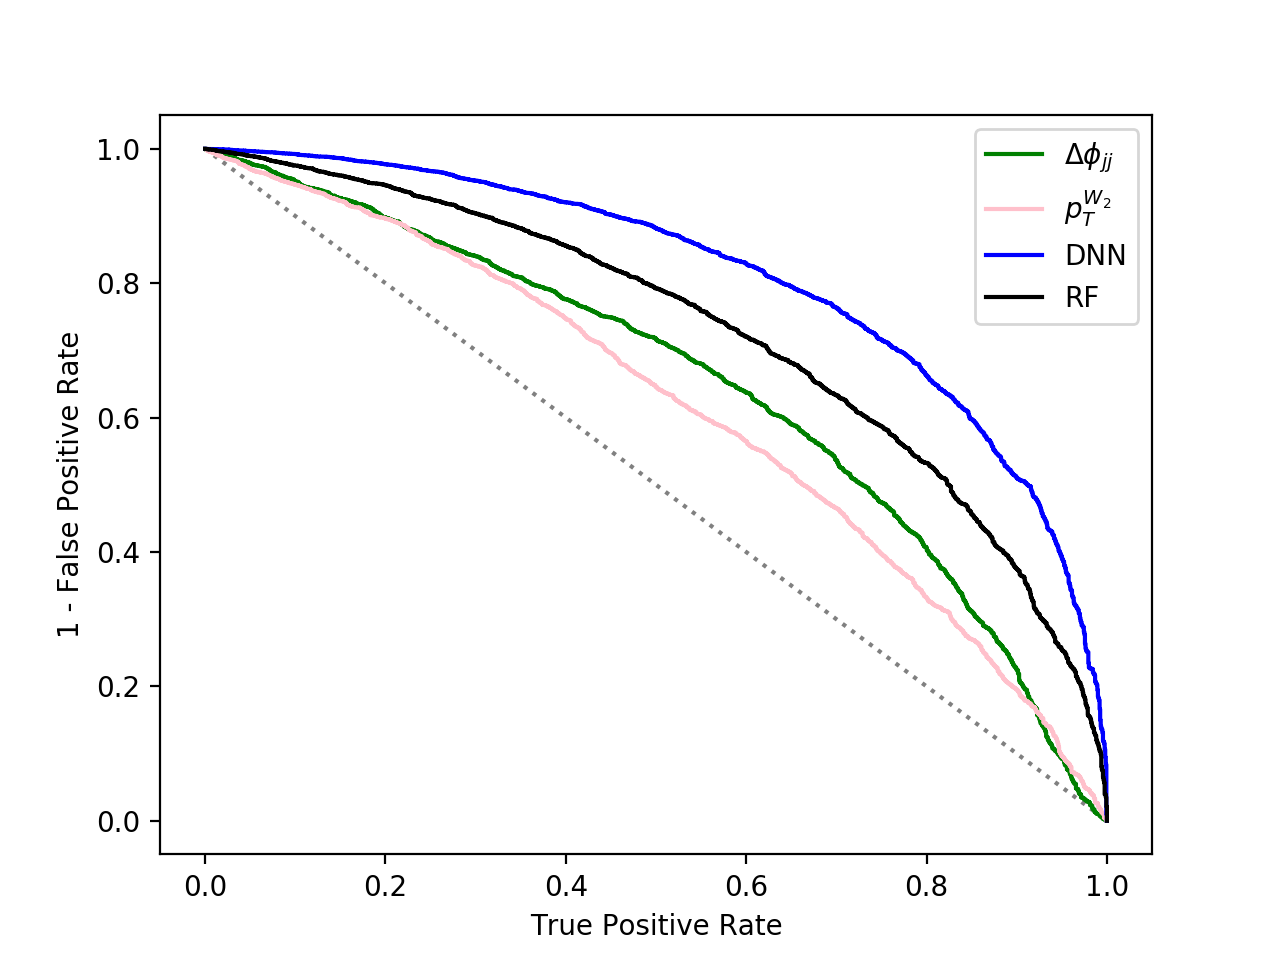

In [25]:
roc_comparison()

The ROC curve shows range of possible True and False Positive Rates depending on where discrimant threshold is set. To get a feel for what would be good choices for the thresholds we visualize kinematic distributions and ML discriminants

### Kinematic distributions and ML discriminants

In [26]:
def kin_dist():
    plt.figure(2, figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(dfww[dfww['n_lon'] == 2]['pT.W2'],
             bins=np.linspace(0, 1800, 36),
             normed=True,
             histtype='step',
             color='r',
             label='LL')
    plt.hist(dfww[dfww['n_lon'] != 2]['pT.W2'],
             bins=np.linspace(0, 1800, 36),
             normed=True,
             histtype='step',
             color='b',
             label='TT+TL')
    plt.xlabel(r'$p_T^{W2}$')
    plt.xlim(0, 500)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.hist(dfww[dfww['n_lon'] == 2]['delta_phi.jj'],
             normed=True,
             histtype='step',
             color='r',
             label='LL')
    plt.hist(dfww[dfww['n_lon'] != 2]['delta_phi.jj'],
             normed=True,
             histtype='step',
             color='b',
             label='TT+TL')
    plt.xlabel(r'$\Delta\phi_{jj}$')
    plt.legend(loc=2)
    
    plt.show()

<IPython.core.display.Javascript object>


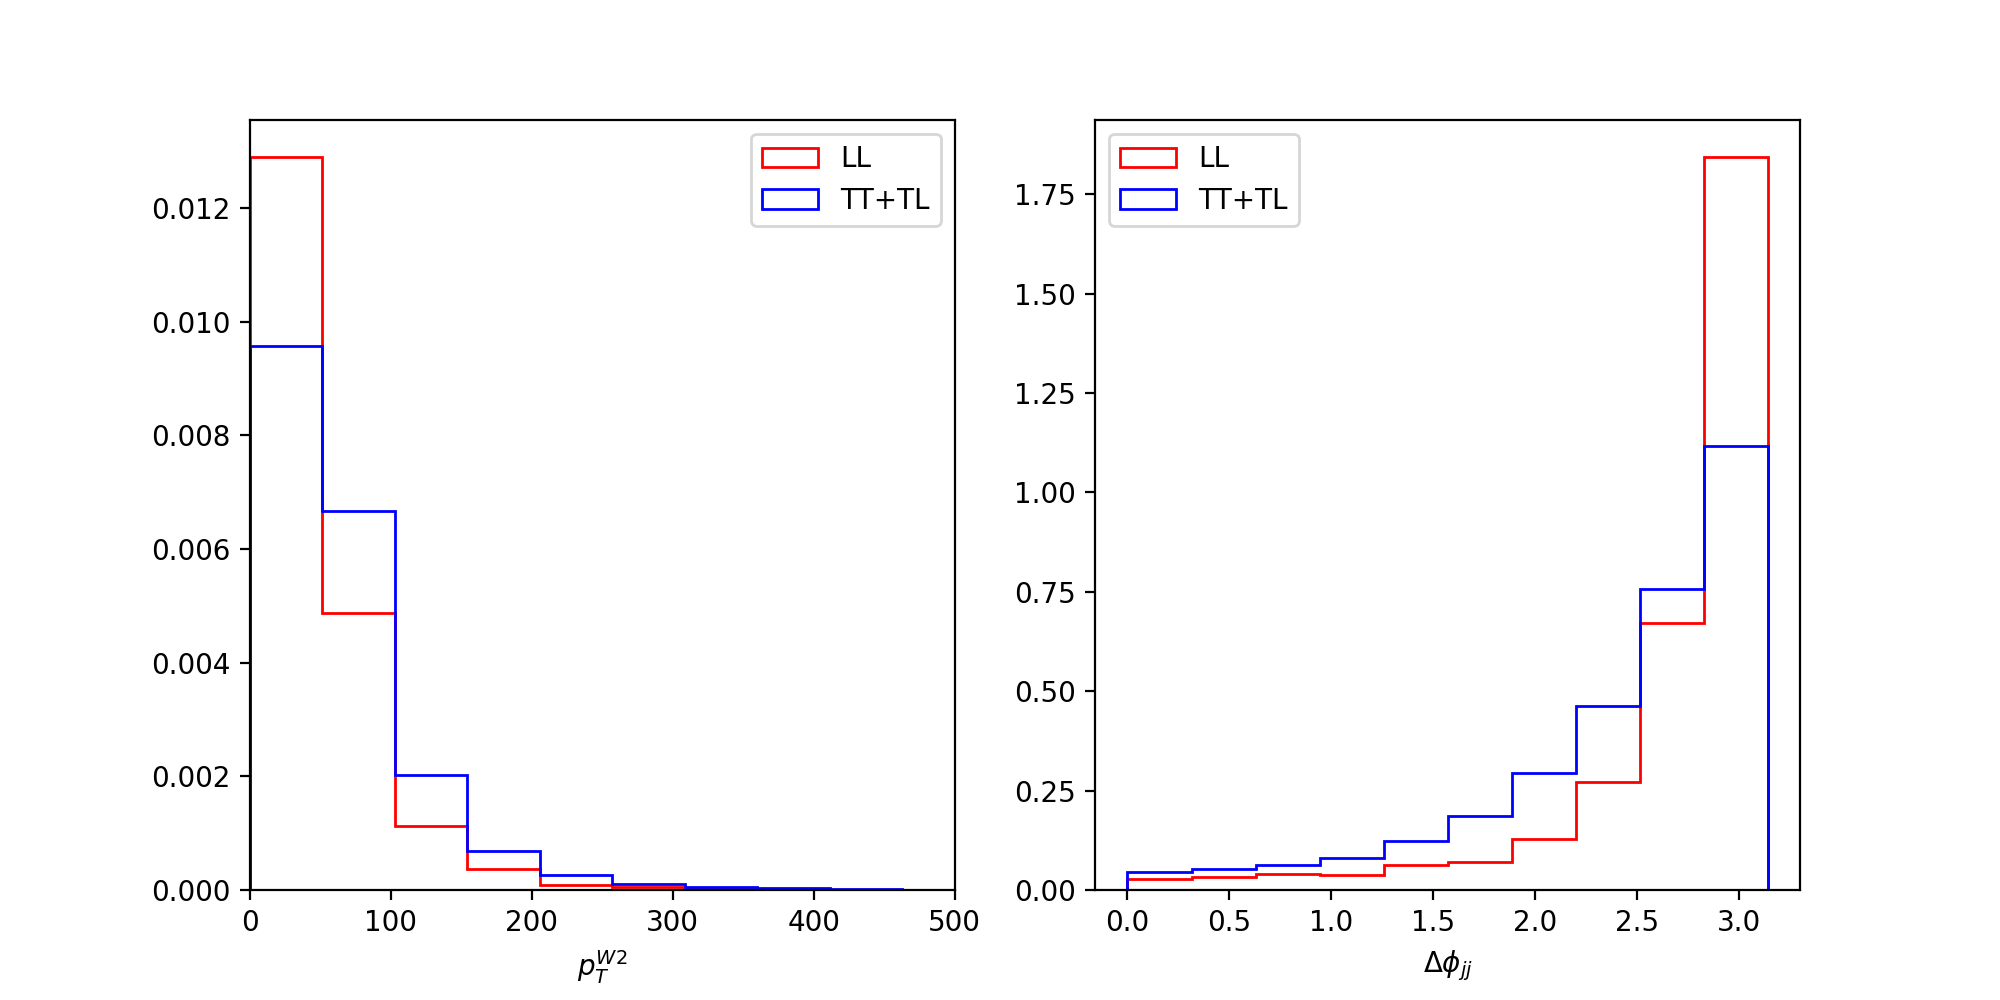

In [27]:
kin_dist()

In [28]:
def discrims():
    plt.figure(3, figsize=(10, 10))
    
    plt.subplot(2, 2, 1)
    plt.hist(log_reg_pTW2.predict_proba(X_tr_pTW2[y_tr == 1]).T[1],
             normed=True,
             histtype='step',
             color='r',
             label='LL')
    plt.hist(log_reg_pTW2.predict_proba(X_tr_pTW2[y_tr == 0]).T[1],
             normed=True,
             histtype='step',
             color='b',
             label='TT+TL')
    plt.xlabel(r'$p_T^{W2}$ discriminant')
    plt.legend()
    
    plt.subplot(2, 2, 2)
    plt.hist(log_reg_phijj.predict_proba(X_tr_phijj[y_tr == 1]).T[1],
             normed=True,
             histtype='step',
             color='r',
             label='LL')
    plt.hist(log_reg_phijj.predict_proba(X_tr_phijj[y_tr == 0]).T[1],
             normed=True,
             histtype='step',
             color='b',
             label='TT+TL')
    plt.xlabel(r'$\Delta\phi_{jj}$ discriminant')
    plt.legend(loc=2)
    
    plt.subplot(2, 2, 3)
    plt.hist(rfc.predict_proba(X_tr[y_tr == 1]).T[1],
             normed=True,
             histtype='step',
             color='r',
             label='LL')
    plt.hist(rfc.predict_proba(X_tr[y_tr == 0]).T[1],
             normed=True,
             histtype='step',
             color='b',
             label='TT+TL')
    plt.xlabel('Random Forest discriminant')
    plt.legend()
    
    plt.subplot(2, 2, 4)
    plt.hist(keras_model.predict_proba(X_tr_dnn[y_tr == 1]),
             normed=True,
             histtype='step',
             color='r',
             label='LL')
    plt.hist(keras_model.predict_proba(X_tr_dnn[y_tr == 0]),
             normed=True,
             histtype='step',
             color='b',
             label='TT+TL')
    plt.xlabel('DNN discriminant')
    plt.legend()
    
    plt.show()

<IPython.core.display.Javascript object>


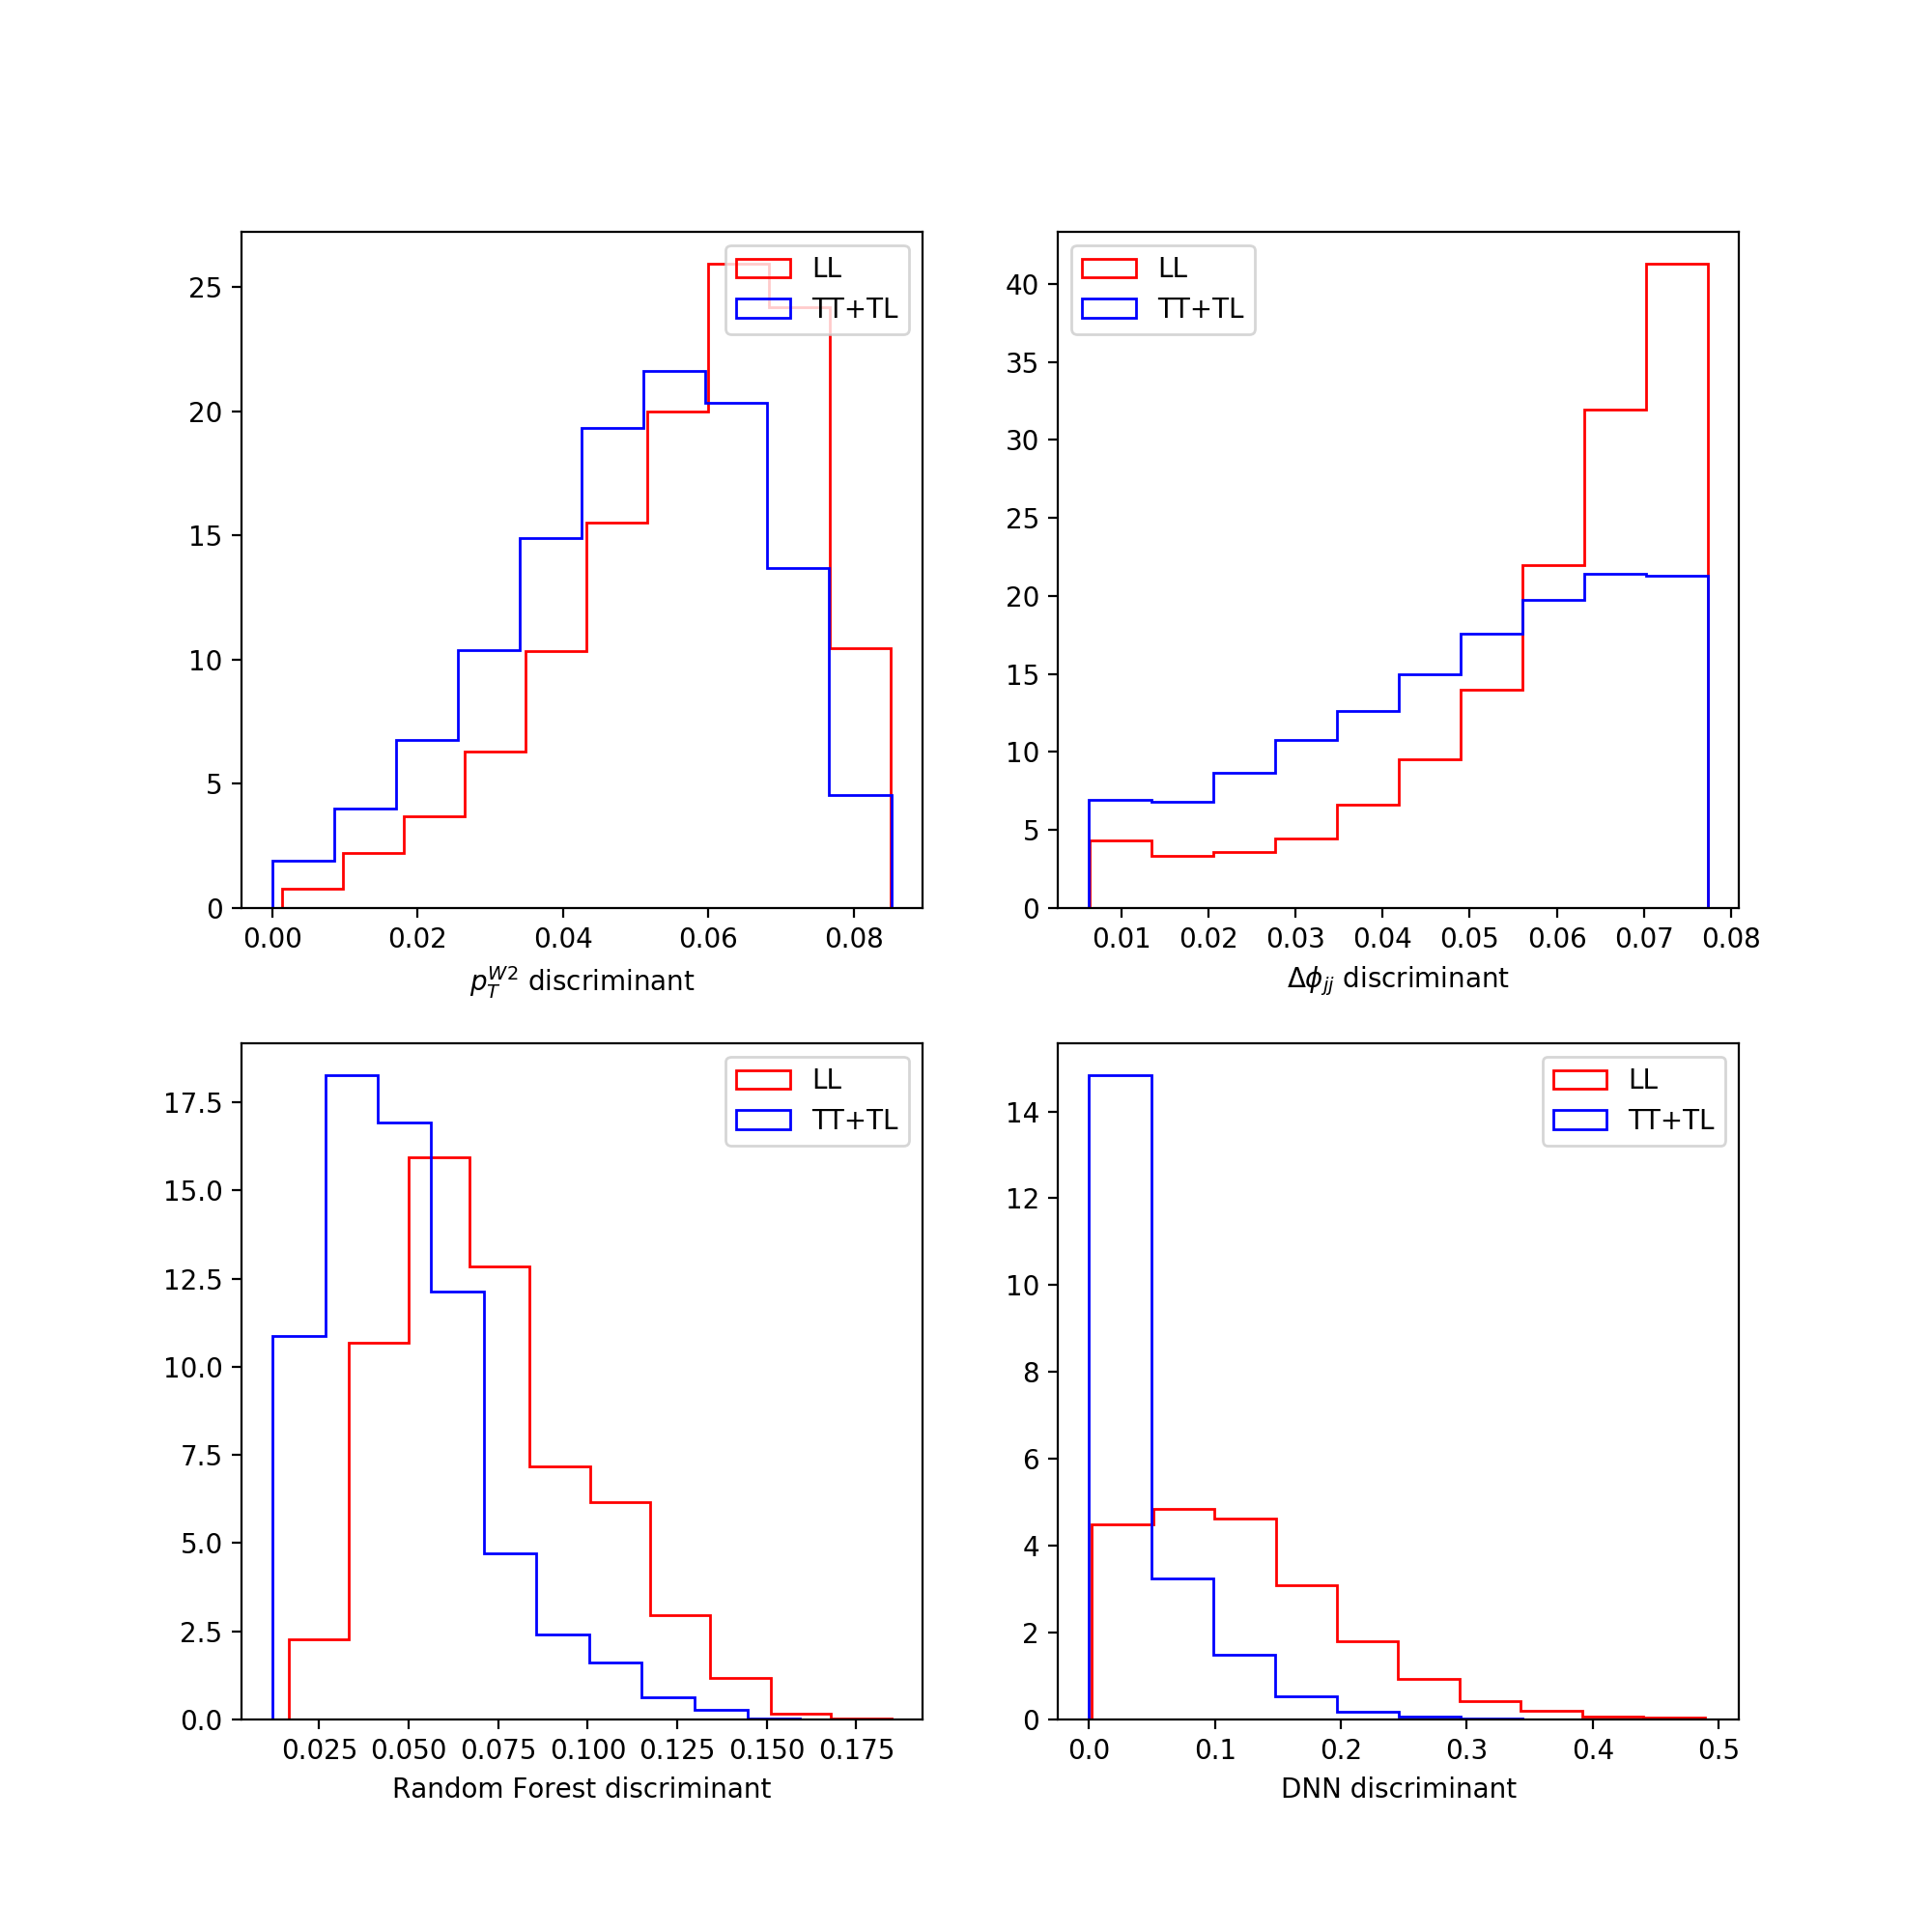

In [29]:
discrims()

## Fit to LL fraction

We can fit to the above discriminant distributions, and extract the most likely value of the LL fraction and its uncertainty using the method of maximum likelihood. The log-likelihood function is
\begin{equation}
-\log\left(L(\mu)\right) = -\sum_e \log\left(\mu\, f_{LL}(x_e) + (1 - \mu)\, f_{TT+TL}(x_e)\right)
\end{equation}
where $\mu$ is the $LL$ polarization fraction, and $f_i$ is the pdf for the probability that an ML model predicts an event to be class $i$. We will rescale the LL to 300/fb of data.

In [30]:
from src.compute_LL import logLikelihood

In [31]:
log_like = logLikelihood()

In [32]:
mLL_phijj = log_like.compute_log_likelihood(log_reg_phijj, X_te_phijj, y_te) / log_like.rescale

/Users/christopherwmurphy/Documents/Research/NNtest/Class-Imbalance-in-WW-Polarization/src/compute_LL.py:28: RuntimeWarning: divide by zero encountered in log
  mLL = -np.log(mu * pdf_1 + (1 - mu) * pdf_0)


The divide by zero warning is caused by a small fracion of events $O(10^{-5})$ where the probability of both classes is predicted to be zero

In [34]:
mLL_pTW2 = log_like.compute_log_likelihood(log_reg_pTW2, X_te_pTW2, y_te) / log_like.rescale

/Users/christopherwmurphy/Documents/Research/NNtest/Class-Imbalance-in-WW-Polarization/src/compute_LL.py:28: RuntimeWarning: divide by zero encountered in log
  mLL = -np.log(mu * pdf_1 + (1 - mu) * pdf_0)


In [35]:
mLL_rfc = log_like.compute_log_likelihood(rfc, X_te, y_te) / log_like.rescale

/Users/christopherwmurphy/Documents/Research/NNtest/Class-Imbalance-in-WW-Polarization/src/compute_LL.py:28: RuntimeWarning: divide by zero encountered in log
  mLL = -np.log(mu * pdf_1 + (1 - mu) * pdf_0)


In [36]:
mLL_dnn = log_like.compute_log_likelihood(keras_model, X_te_dnn, y_te) / log_like.rescale

/Users/christopherwmurphy/Documents/Research/NNtest/Class-Imbalance-in-WW-Polarization/src/compute_LL.py:28: RuntimeWarning: divide by zero encountered in log
  mLL = -np.log(mu * pdf_1 + (1 - mu) * pdf_0)


In [37]:
def plot_LL():
    plt.figure(4)
    
    CLs = ['68% CL', '90% CL', '95% CL']
    deltas = np.array([1.0, 1.64, 1.96])**2/2
    for i in range(len(CLs)):
        plt.hlines(deltas[i],
                   0.0,
                   0.12,
                   colors='gray',
                   alpha=0.2)
        #plt.annotate(CLs[i], xy=(0.1, deltas[i] - 0.07))
 
    mus = log_like.mus
    plt.plot(mus,
             mLL_pTW2 - np.min(mLL_pTW2),
             c='pink',
             label=r'$p_T^{W2}$')
    plt.plot(mus,
             mLL_phijj - np.min(mLL_phijj),
             c='g',
             label=r'$\Delta\phi_{jj}$')
    plt.plot(mus,
             mLL_rfc - np.min(mLL_rfc),
             c='k',
             label='RF')
    plt.plot(mus,
             mLL_dnn - np.min(mLL_dnn),
             c='b',
             label='DNN')
    
    plt.xlim(0.0, 0.12)
    plt.ylim(0.0, 2.0)
    plt.xlabel(r'$\mu$')
    plt.ylabel(r'max$(L(\mu)) - L(\mu)$')
    plt.title('Predicted LL fraction')
    plt.legend()
    plt.savefig('../results/predicted_LL_fraction.png')
    plt.show()

<IPython.core.display.Javascript object>


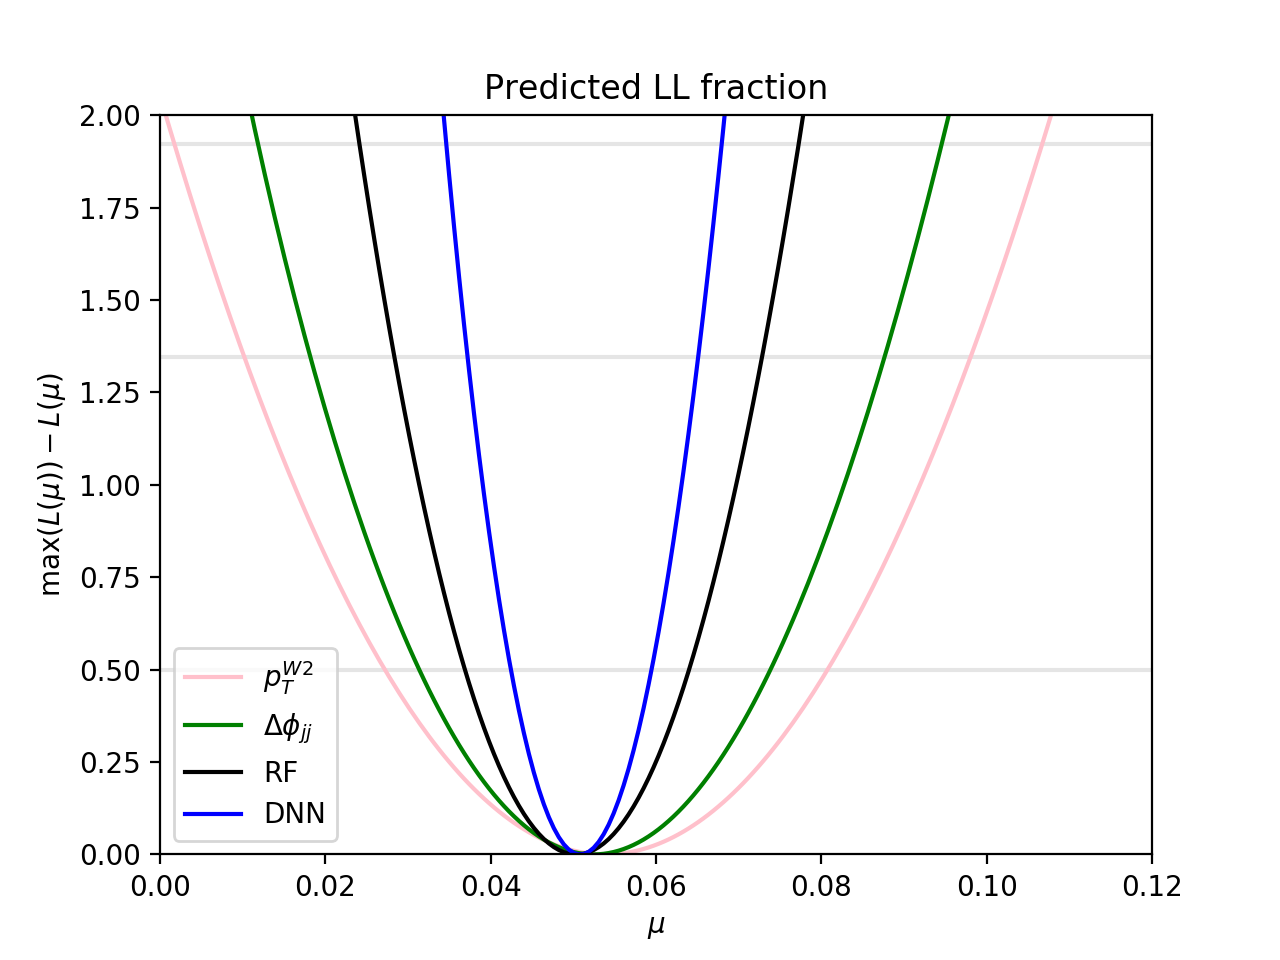

In [38]:
plot_LL()

# Polarization Fraction in same-sign $WW$ scattering as a Class Imbalance problem

## Consider Different Metrics

Let's start by evaluating the models we've already trained with some different metrics. 

In [39]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve

### Precision-Recall Curve

When dealing with class imbalance total accuracy is not a good metric to use as it won't be concerned with the minority class we are interested in. Precision and Recall are better metrics to use. Precision is the ratio of True Positives over the sum of True and False Positives. Recall is the ratio of True Positive over the sum of True Positives and False Negatives. Recall is equivalent to the True Positive Rate in the ROC curve. The Precision-Recall curve is better to use for class imbalance problems than the ROC curve because is more concerned with True Negatives than False Postives or Negatives.

In [40]:
precisions_phijj, recalls_phijj, threshold_phijj = precision_recall_curve(y_te, probas_phijj.T[1])
precisions_dnn, recalls_dnn, threshold_dnn = precision_recall_curve(y_te, probas_dnn)
precisions_pTW2, recalls_pTW2, threshold_pTW2 = precision_recall_curve(y_te, probas_pTW2.T[1])
precisions_rfc, recalls_rfc, threshold_rfc = precision_recall_curve(y_te, probas_rfc.T[1])

In [41]:
def PR_curve():
    plt.figure(5)
    
    f1_scores = np.linspace(0.2, 0.8, num=4)
    for f1_score in f1_scores:
        x = np.linspace(0.01, 1)
        y = f1_score * x / (2 * x - f1_score)
        plt.plot(x[y >= 0],
                 y[y >= 0],
                 color='gray',
                 alpha=0.2)
        plt.annotate(r'$f_1$={0:0.1f}'.format(f1_score), xy=(0.9, y[45] + 0.02))
    
    plt.plot(recalls_phijj,
             precisions_phijj,
             label = r'$\Delta\phi_{jj}$',
             c = 'g')
    plt.plot(recalls_pTW2,
             precisions_pTW2,
             label = r'$p_T^{W_2}$',
             c = 'pink')
    plt.plot(recalls_dnn,
             precisions_dnn,
             label = 'DNN',
             c = 'b')
    plt.plot(recalls_rfc,
             precisions_rfc,
             label = 'RF',
             c = 'k')
    
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.savefig('../results/PR_curve.png')
    plt.show()

<IPython.core.display.Javascript object>


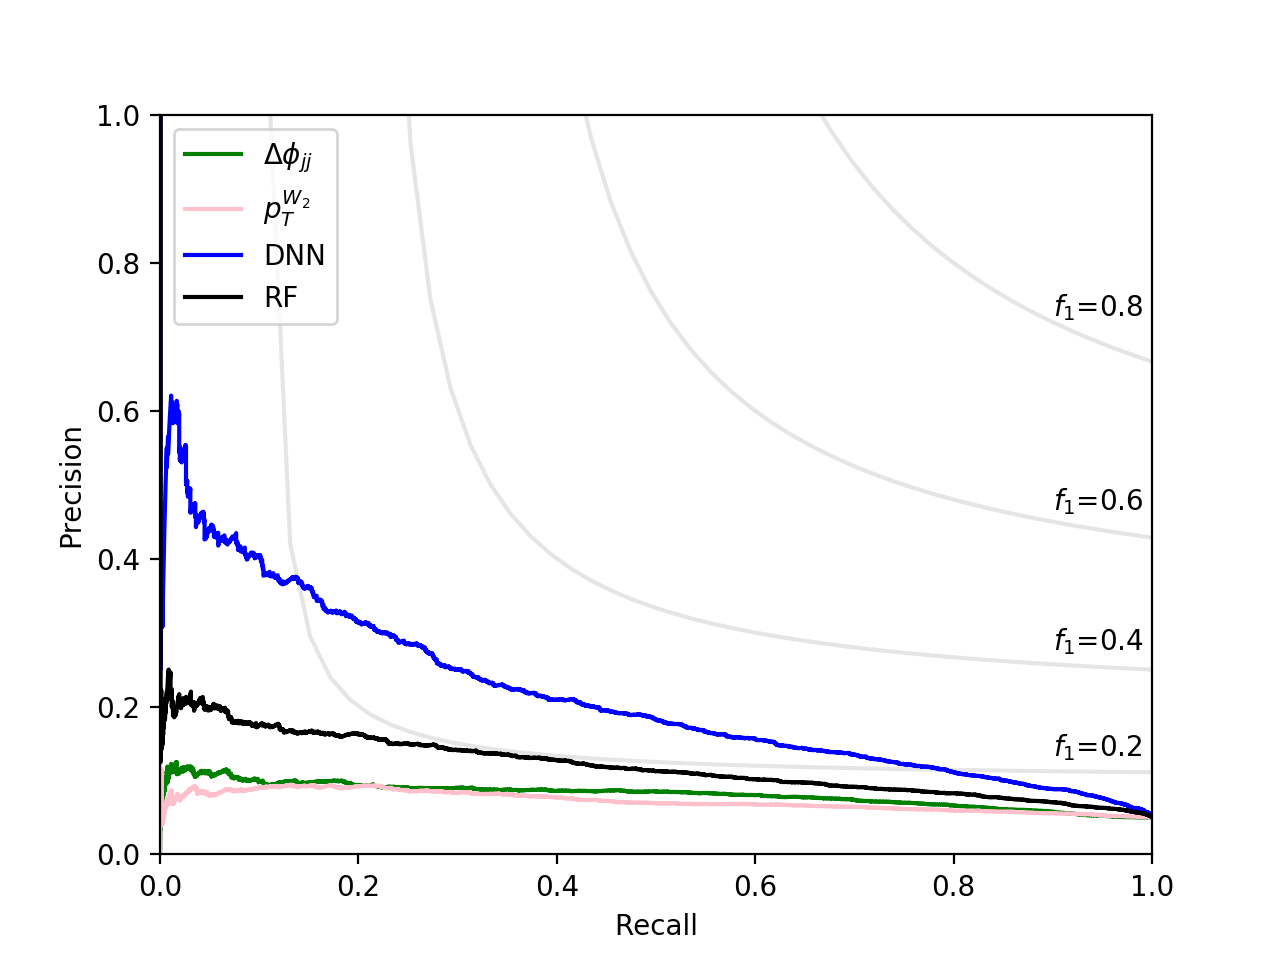

In [42]:
PR_curve()

Also plotted in Figure 3 are iso-contours of $f_1$ score. $f_1$ is defined as twice the haronic sum of precision and recall, and is useful if a single number is needed to summarize the performance of a model on a class imbalance problem.

### Confusion Matrix, Precision, Recall, $f_1$ Score

For each model let's look at how it performs when its threshold is optimized to maximize $f_1$ score.

In [43]:
def f1s(precisions, recalls):
    return 2 * precisions * recalls / (precisions + recalls)

First up is our deep neural network

In [44]:
f1_dnn = f1s(precisions_dnn[:-10], recalls_dnn[:-10])
thres_dnn = threshold_dnn[np.argmax(f1_dnn)]

In [45]:
confusion_matrix(y_te, probas_dnn > thres_dnn)

array([[27890,  2508],
       [  935,   667]])

In [46]:
print(classification_report(y_te, probas_dnn > thres_dnn))

              precision    recall  f1-score   support

       False       0.97      0.92      0.94     30398
        True       0.21      0.42      0.28      1602

   micro avg       0.89      0.89      0.89     32000
   macro avg       0.59      0.67      0.61     32000
weighted avg       0.93      0.89      0.91     32000



Next is the jet angular observable, which has a better recall, but lower precision and f1-score than the dnn

In [47]:
f1_phijj = f1s(precisions_phijj[:-25], recalls_phijj[:-25])
thres_phijj = threshold_phijj[np.argmax(f1_phijj)]

In [48]:
confusion_matrix(y_te, probas_phijj.T[1] > thres_phijj)

array([[22614,  7784],
       [  861,   741]])

In [49]:
print(classification_report(y_te, probas_phijj.T[1] > thres_phijj))

              precision    recall  f1-score   support

       False       0.96      0.74      0.84     30398
        True       0.09      0.46      0.15      1602

   micro avg       0.73      0.73      0.73     32000
   macro avg       0.53      0.60      0.49     32000
weighted avg       0.92      0.73      0.80     32000



3rd up is the $p_T$ of the trailing $W$. This was the worst of our models

In [51]:
f1_pTW2 = f1s(precisions_pTW2[:-15], recalls_pTW2[:-15])
thres_pTW2 = threshold_pTW2[np.argmax(f1_pTW2)]

In [52]:
confusion_matrix(y_te, probas_pTW2.T[1] > thres_pTW2)

array([[24294,  6104],
       [ 1055,   547]])

In [53]:
print(classification_report(y_te, probas_pTW2.T[1] > thres_pTW2))

              precision    recall  f1-score   support

       False       0.96      0.80      0.87     30398
        True       0.08      0.34      0.13      1602

   micro avg       0.78      0.78      0.78     32000
   macro avg       0.52      0.57      0.50     32000
weighted avg       0.91      0.78      0.83     32000



Last, but not least is the random forest. The RF has the 2nd highest precision and f1-scores

In [54]:
f1_rfc = f1s(precisions_rfc[:-10], recalls_rfc[:-10])
thres_rfc = threshold_rfc[np.argmax(f1_rfc)]

In [55]:
confusion_matrix(y_te, probas_rfc.T[1] > thres_rfc)

array([[26908,  3490],
       [ 1052,   550]])

In [56]:
print(classification_report(y_te, probas_rfc.T[1] > thres_rfc))

              precision    recall  f1-score   support

       False       0.96      0.89      0.92     30398
        True       0.14      0.34      0.19      1602

   micro avg       0.86      0.86      0.86     32000
   macro avg       0.55      0.61      0.56     32000
weighted avg       0.92      0.86      0.89     32000



## Different Models

The above models were not optimized for class imbalance problems. We consider a few different strategies to try to address this issue.

### Class Weights

Weight the classes inversely proportional to class frequencies in the input data. This corresponds to setting class_weight='balanced' in scikit-learn. Keras also has a class_weight option. You just need to define what is meant by balanced.

### Balanced Random Forest

Randomly under-sample each boostrap sample to balance it. The idea is originally from [this](https://dl.acm.org/citation.cfm?id=2118190) paper, which I don't have access to? More info can be found [here](https://www.svds.com/learning-imbalanced-classes/#fn4), and [there](https://imbalanced-learn.org/en/stable/generated/imblearn.ensemble.BalancedRandomForestClassifier.html#imblearn.ensemble.BalancedRandomForestClassifier)

### Focal Loss

A novel loss that adds a factor $(1 - p_t)^{\gamma}$ to the standard cross entropy criterion. Setting $\gamma > 0$ reduces the relative loss for well-classified examples $(p_t > 0.5)$, putting more focus on hard, misclassified examples. From arXiv:1708.02002

### Balanced Batch Generator

Create balanced batches when training a neural network. See the [documentation](https://imbalanced-learn.org/en/stable/generated/imblearn.keras.BalancedBatchGenerator.html#imblearn.keras.BalancedBatchGenerator) article for more info

### Oversampling the minority class

I found that oversampling the minority class led to overfitting, and worse performance on the test set. Training also took along because of the additional (synthetic) data.

## Results for Different Models

I ran the above models offline, and scored them on their Average Precision, ROC AUC and an estimate of the significance of the LL fraction measurement. The classic ML was run on my MacBook Pro. The DL models were trained on a GPU hosted by AWS (p2.xlarge).

In [1]:
from src.utils import pkl_load_obj
from src.analysis import classification_report

In [2]:
classical_scores = pkl_load_obj('classical_scores')

In [3]:
deep_scores = pkl_load_obj('deep_scores')

In [4]:
for name, scores in classical_scores.items():
    print(name + '\n--------------------')
    classification_report(scores)
    print('\n')

Delta phi_jj
--------------------
Time / Fold = 0.2 +/- 0.0 s
Average Precision = 0.081 +/- 0.003
ROC AUC = 0.647 +/- 0.007
Significance = 2.4 +/- 0.1


Random Forest 1000/5
--------------------
Time / Fold = 118.2 +/- 3.7 s
Average Precision = 0.122 +/- 0.007
ROC AUC = 0.732 +/- 0.009
Significance = 3.9 +/- 0.1


Weighted Random Forest 1000/10, 1:3
--------------------
Time / Fold = 198.4 +/- 1.5 s
Average Precision = 0.140 +/- 0.009
ROC AUC = 0.759 +/- 0.008
Significance = 4.4 +/- 0.2


Balanced Random Forest 1000/None
--------------------
Time / Fold = 46.9 +/- 0.3 s
Average Precision = 0.148 +/- 0.008
ROC AUC = 0.773 +/- 0.007
Significance = 4.6 +/- 0.2


Random Forest 1000/10
--------------------
Time / Fold = 205.7 +/- 4.9 s
Average Precision = 0.137 +/- 0.009
ROC AUC = 0.755 +/- 0.007
Significance = 4.5 +/- 0.2


Weighted Random Forest 1000/None, balanced subsample
--------------------
Time / Fold = 275.8 +/- 1.3 s
Average Precision = 0.149 +/- 0.006
ROC AUC = 0.775 +/- 0.005
Si

In [5]:
for name, scores in deep_scores.items():
    print(name + '\n--------------------')
    classification_report(scores)
    print('\n')

DNN
--------------------
Time / Fold = 218.8 +/- 24.4 s
Average Precision = 0.230 +/- 0.015
ROC AUC = 0.820 +/- 0.007
Significance = 6.5 +/- 0.3


DNN w/ Focal Loss g=2.0, a=0.25
--------------------
Time / Fold = 228.8 +/- 37.7 s
Average Precision = 0.232 +/- 0.020
ROC AUC = 0.821 +/- 0.011
Significance = 6.3 +/- 0.4


DNN w/ Focal Loss g=0.5, a=0.5
--------------------
Time / Fold = 211.0 +/- 29.2 s
Average Precision = 0.232 +/- 0.018
ROC AUC = 0.820 +/- 0.008
Significance = 6.3 +/- 0.4


DNN w/ Focal Loss g=0.2, a=0.75
--------------------
Time / Fold = 200.3 +/- 37.2 s
Average Precision = 0.227 +/- 0.020
ROC AUC = 0.818 +/- 0.009
Significance = 6.1 +/- 0.3


Balanced Batch DNN
--------------------
Time / Fold = 88.6 +/- 16.8 s
Average Precision = 0.182 +/- 0.013
ROC AUC = 0.797 +/- 0.008
Significance = 5.3 +/- 0.3




Results:
- The central values of AP and AUC increased for the Weighted and Balanced Random Forest w.r.t. the standard RF. In the case of the AUC this was a statistically significant increase
- The Balanced Random Forest sped up training time considerably, 2.5x, w.r.t. the standard RF
- Focal Loss did not improve the performance of the DNN in a statistically significant way. However no hyperparameter tuning has been done, whereas a grid search was performed for the RFs.
- The Balanced Batch DNN trained faster, but had worse performance

## Feature Importance

In [57]:
from imblearn.ensemble import BalancedRandomForestClassifier

In [58]:
brfc = BalancedRandomForestClassifier(n_estimators=1000)

(brfc
 .fit(X, y))

BalancedRandomForestClassifier(bootstrap=True, class_weight=None,
                criterion='gini', max_depth=None, max_features='auto',
                max_leaf_nodes=None, min_impurity_decrease=0.0,
                min_samples_leaf=2, min_samples_split=2,
                min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
                oob_score=False, random_state=None, replacement=False,
                sampling_strategy='auto', verbose=0, warm_start=False)

In [59]:
sorted((np
        .array([dfww.columns.drop('n_lon').values, np.round(100 * brfc.feature_importances_, 2)])
        .T
        .tolist()),
       key=lambda x: x[1],
       reverse=True)

[['delta_phi.jj', 9.03],
 ['pT.W2', 6.85],
 ['mm.WW', 5.45],
 ['pT.W1', 4.98],
 ['delta_eta.jj', 4.87],
 ['pT.WW', 4.85],
 ['pT.j2', 4.33],
 ['mm.jj', 4.15],
 ['e.WW', 3.99],
 ['e.W1', 3.97],
 ['pT.j1', 3.95],
 ['eta.j2', 3.9],
 ['e.j2', 3.78],
 ['e.j1', 3.45],
 ['eta.W1', 3.42],
 ['e.W2', 3.36],
 ['phi.W2', 3.32],
 ['eta.j1', 3.31],
 ['eta.W2', 3.25],
 ['phi.j2', 3.24],
 ['eta.WW', 3.23],
 ['phi.j1', 3.17],
 ['phi.W1', 3.09],
 ['phi.WW', 3.04]]

Preliminary Investigations / To Do:
- With a batch size of 1024 one epoch of training took about 1 second on the GPU vs. 3 seconds on my computer. Conversely with a batch size of 50 one epoch took about 30 seconds on the GPU vs. 15 seconds on my computer.
- Adding more hidden layers, 3 or 5 total, did not significantly improve performance either. What about more epochs?